***Notebook 2 of 3***


# ***Faster RCNN***
---
![alt text](https://miro.medium.com/proxy/1*67iVyCzqapfB5Nyci_zynw.png)
>Faster R-CNN is one of the first frameworks which completely works on Deep learning. It is built upon the knowledge of Fast RCNN which indeed built upon the ideas of RCNN. 

In this notebook I will be focusing on the Faster RCNN models and will discuss a bit about FastRCNN, both has almost the same flows but Faster RCNNs perform better therfore the stage will be given to the FasterRCNN.
> Below is a diagram that describes the FastRCNN and FasterRCNN![alt text](https://miro.medium.com/max/700/1*dxnDHyA9srqFKGEKIUdsOA.png)


### Faster RCNN's Flow:
1. **Region Proposal network (RPN)**
>R-CNN and Fast R-CNN first generate region proposals by selective search (SS), then a CNN-based network is used to classify the object class and detect the bounding box. (The main difference is that R-CNN input the region proposals at pixel level into CNN for detection while Fast R-CNN input the region proposals at feature map level.) Thus, in R-CNN and Fast R-CNN, the region proposal approach/network (i.e. SS) and the detection network are decoupled.
Decoupling is not a good idea. It is better to couple them together such that they are correlated to each other.
In Faster R-CNN, RPN using SS is replaced by RPN using CNN. And this CNN is shared with detection network. This CNN can be any model such as, VGG, mobile net ,etc.. in this notebook the CNN model will be resnet101
Briefly, RPN ranks region anchor/boxes (called anchors) and proposes the ones most likely containing objects.
* Anchor - An anchor is a box. In the default configuration of Faster R-CNN, there are 9 anchors at a position of an image. Therefore the number of anchors on each feature map is H\*W\*9, where H is the height and W is the width of the feature map.![alt text](https://miro.medium.com/max/647/1*cPidpSRVUVgv3YeY9Fc11Q.png)

**Basically the RPN network predicts the possibility of an *anchor* being background or foreground, and refine the anchor.**

2. **Region of Interest Pooling (ROI)**

>After RPN, we get proposed regions with different sizes. Different sized regions means different sized CNN feature maps. Region of Interest Pooling can simplify the problem by reducing the feature maps into the same size. Unlike Max-Pooling which has a fix size, ROI Pooling splits the input feature map into a fixed number (let’s say k) of roughly equal regions, and then apply Max-Pooling on every region. Therefore the output of ROI Pooling is always k regardless the size of input. With the fixed ROI Pooling outputs as inputs, we have lots of choices for the architecture of the final classifier and regressor.

![alt text](https://miro.medium.com/max/542/1*wwKCoG-VtBycFeACBES4nA.jpeg)

As I started the paticipation in the competition, I tried to find some models that will fit my purposes and I thought this models is one of the basic models that I should learn to use, and learn about Object Detection tasks.

**NOTE: Functions and Classes are well explained on the first notebook**

# Installations

In [ ]:
!pip install -U -q git+https://github.com/albumentations-team/albumentations
!pip install -q "torch==1.4" "torchvision==0.5.0"
!pip install -q ensemble-boxes

In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import glob
from itertools import product
import os
from typing import List, Union, Tuple
import random
import torch
from torch.utils.data import DataLoader, Dataset

import ensemble_boxes
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device
SEED = 44

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)
DATA_PATH = '/content/drive/My Drive/CV/Global Wheat Detection/train.csv'
TRAIN_ROOT_PATH = '/content/drive/My Drive/CV/Global Wheat Detection/train'
OUTPUT_PATH = '/content/drive/My Drive/CV/checkpoint/effdet_checkpoints/FasterRCNN152'

# Getting the GWD Data

Note: The fasterRCNN model get the input on PASCAL VOC format, information avout those formats are mentioned on the first notebook 

In [5]:
def read_csv(path) -> pd.DataFrame:

    df = pd.read_csv(path)
    bboxes = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

    for i, column in enumerate(['x_min', 'y_min', 'width', 'height']):
        df[column] = bboxes[:,i]
    
    df["x_max"] = df.apply(lambda col: col.x_min + col.width, axis=1)
    df["y_max"] = df.apply(lambda col: col.y_min + col.height, axis=1)
    df["area"] = df.apply(lambda col: col.width * col.height, axis=1)
    df["class"] = 1 # 1 for wheat, 0 for background

    df.drop(columns=['source'], inplace=True)
    df.drop(columns=['bbox'], inplace=True)

    return df

gwd_df = read_csv(DATA_PATH)  

# Augmetations - Albumentations

In [6]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.ToGray(p=0.02),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

# Wheat Dataset

In [7]:
class WheatDataset(Dataset):

    def __init__(self, marking, image_ids, is_val=False , transforms=None):
        super().__init__()
        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.is_val = is_val

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.is_val or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            # Use cutmix augmentation
            image, boxes = self.load_cutmix_image_and_boxes(index)

        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        records = self.marking[self.marking['image_id'] == image_id]
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        target['area'] = torch.as_tensor(records["area"].values, dtype=torch.float64)

        # suppose all instances are not crowd
        target['iscrowd'] = iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)

        if self.transforms:
            # The crop augmentation may crop bounding boxes
            # loop untill it will have bonding boxes
            for i in range(20):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0: 
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x_min', 'y_min', 'x_max', 'y_max']].values
        return image, boxes

    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

In [8]:
from torch.utils.data.sampler import SequentialSampler, RandomSampler

def collate_fn(batch):
    return tuple(zip(*batch))

num_workers = 4
BATCH_SIZE = 4

image_ids = gwd_df['image_id'].unique()
# image_ids = image_ids[:50] # for sanity test
train_ids, valid_ids = train_test_split(image_ids, test_size=0.1, random_state=SEED)

train_dataset = WheatDataset(gwd_df, image_ids=train_ids, transforms=get_train_transforms())
validation_dataset = WheatDataset(gwd_df, image_ids=valid_ids, is_val=True, transforms=get_valid_transforms())

train_loader = DataLoader(train_dataset,batch_size=BATCH_SIZE,sampler=RandomSampler(train_dataset), drop_last=True, num_workers=num_workers, collate_fn=collate_fn)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, num_workers=num_workers, sampler=SequentialSampler(validation_dataset), collate_fn=collate_fn,)


# Model Initialization

Before diving into Training I had to learn about how to build the FasterRCNN model and the input and the output of the model. Luckily Pytorch provided a tutorial about the use of their detection models and can be found [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html), there they give a basic tutorial of how to build the MaskRCNN models, dataset and dataloader.

In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN, resnet_fpn_backbone
from torch.optim import SGD, Adam, lr_scheduler
from torch.optim.lr_scheduler import StepLR

def fasterrcnn_resnet101_fpn(num_classes=2, pretrained_backbone=True,cp_path=None):
    # init FPN model with Resnet101 as backbone
    backbone = resnet_fpn_backbone('resnet101', pretrained=pretrained_backbone)
    # init Faster RCNN model
    model = FasterRCNN(backbone, num_classes)                 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 2)
    if cp_path is not None:
        model_dict = torch.load(cp_path)
        try:
            model.load_state_dict(model_dict)
        except:
            model.load_state_dict(model_dict['model_state_dict'])

    del model_dict
    gc.collect()

    return model


In [10]:
class AverageMeter(object):
    """
        Computes and stores the average and current value
        decouples the loss calculation from the train and eval functions
    """
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def save(path, model, optimizer, scheduler, epoch, best_summary_loss, train_loss_list, val_loss_list):
    model.eval()
    torch.save(
        {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_summary_loss': best_summary_loss,
        'epoch': epoch,
        'train_loss_list' : train_loss_list,
        'val_loss_list' : val_loss_list,
    }, f'{OUTPUT_PATH}/cp_fasterRCNN{epoch}.pth')

def load(path, model, optimizer, scheduler):
    checkpoint = torch.load(path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    best_summary_loss = checkpoint['best_summary_loss']
    epoch = checkpoint['epoch'] + 1
    train_loss_list = checkpoint['train_loss_list']
    val_loss_list = checkpoint['val_loss_list']

    return model, optimizer, scheduler, epoch, best_summary_loss, train_loss_list, val_loss_list

def train_one_epoch(data_loader, model, optimizer, epoch):
    model.train() 
    summary_loss = AverageMeter()
    tk0 = tqdm(data_loader, total=len(data_loader),desc=f"Epoch {epoch} Train" )
    for step, (images, targets, image_ids) in enumerate(tk0):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        optimizer.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        tk0.set_postfix(loss=summary_loss.avg)
    return model, summary_loss

def evaluate(data_loader, model, epoch):
    model.train()
    summary_loss = AverageMeter()
    with torch.no_grad():
        tk0 = tqdm(data_loader, total=len(data_loader),desc=f"Epoch {epoch} Evaluation" )
        for step, (images, targets, image_ids) in enumerate(tk0):     
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
    return summary_loss  

def fit_model(model, train_loader, valid_loader, optimizer, scheduler, path=None):
    train_loss_list, val_loss_list = [],[]
    if path is not None:
        model, optimizer, scheduler, start, best_loss, train_loss_list, val_loss_list = load(path,
                                                             model,
                                                             optimizer,
                                                             scheduler)
    else: 
        best_loss = 10**5
        start=0

    try:     
        for epoch in range(start,EPOCHS):
            model, train_loss = train_one_epoch(train_loader, model, optimizer, epoch=epoch)
            valid_loss = evaluate(valid_loader, model, epoch=epoch)

            train_loss_list.append(train_loss)
            val_loss_list.append(valid_loss)

            print(f'EPOCH {epoch+1} :: TRAIN_LOSS: {train_loss.avg:.4f} :: VALID_LOSS: {valid_loss.avg:.4f} :: LR: {optimizer.param_groups[0]["lr"]}')

            if valid_loss.avg < best_loss:
                best_loss = valid_loss.avg
                print('Best model found in Epoch {}........Saving Model'.format(epoch+1))   
                model.eval()       
                torch.save(model.state_dict(), f'{OUTPUT_PATH}/FasterRCNN_best.pth')

            save(f'{OUTPUT_PATH}/FasterRCNN101_{epoch+1}.pth',
                 model, optimizer, scheduler, epoch,
                 best_loss, train_loss_list=train_loss_list, val_loss_list=val_loss_list)

            if scheduler is not None:
                scheduler.step(metrics=valid_loss.avg)

    except Exception as e:
        # Found that cataching the exception will prevent Cuda Out Of memeory error
        torch.cuda.empty_cache()
        gc.collect()
        print(e)

    return model

def collate_fn(batch):
    return tuple(zip(*batch))


# Faster RCNN - Training

In [11]:
EPOCHS = 30 
lr = 0.0001

model = fasterrcnn_resnet101_fpn()
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler_params = dict(
    factor=0.5, # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=1, # Number of epochs with no improvement after which learning rate will be reduced.
    threshold_mode='abs', # schedular indication to define what is the not improved state dynamic_threshold = best - threshold(1e-4)
    min_lr=1e-8, #  A lower bound on the learning rate
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, **scheduler_params)
model = fit_model(model, train_loader, val_loader, optimizer, scheduler)

# Evaluation

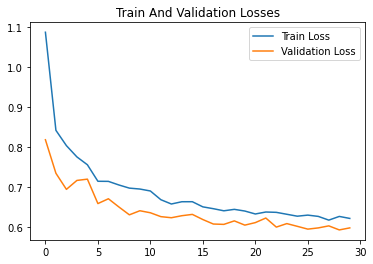

In [12]:
cp = torch.load(f'{OUTPUT_PATH}/cp_fasterRCNN29.pth')
t_losses, v_losses = [l.avg for l in cp['train_loss_list']], [l.avg for l in cp['val_loss_list']]
plt.plot(t_losses[:30])
plt.plot(v_losses[:30])
plt.title("Train And Validation Losses")
plt.legend(['Train Loss','Validation Loss'])
# plt.axis('off')
plt.show()
del cp
gc.collect();

In [20]:
model = fasterrcnn_resnet101_fpn(pretrained_backbone=False,cp_path=f'{OUTPUT_PATH}/cp_fasterRCNN29.pth')
model.to(device)
model.eval();

In [21]:

result = []
for index,(images, targets, _) in enumerate(val_loader):  
    images = list(image.to(device) for image in images)
    outputs = model(images)
    result.append(outputs)
    break

    

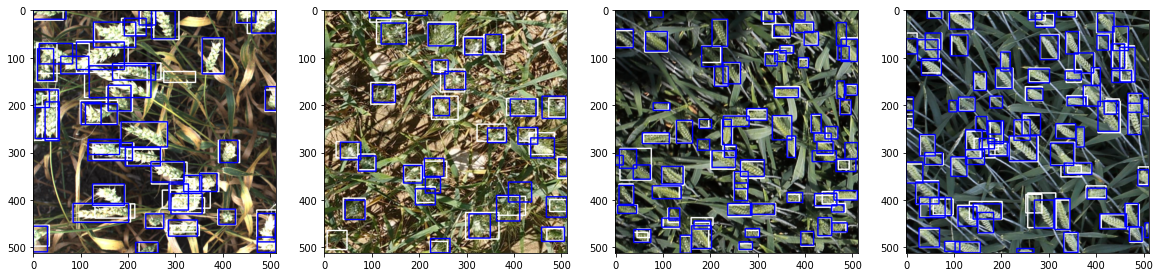

In [22]:
threshold = 0.5
for prediction in result:
    fig, ax = plt.subplots(1, 4, figsize=(20, 8))
    for index in range(4):
        image = images[index].permute(1,2,0).cpu().numpy()
        gt_boxes = targets[index]['boxes'].cpu()
        pr_boxes = prediction[index]['boxes'].cpu()
        pr_scores = prediction[index]['scores'].cpu()
        for box in gt_boxes:
            cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (1,1,1), 2)
        for box, score in zip(pr_boxes, pr_scores):
            if score > threshold: # filter lower score from the threshold
                cv2.rectangle(image, (box[0], box[1]), (box[2],  box[3]), (0,0,1), 2)
        ax[index].imshow(image)


    

# Summary
For a first model I was really impressed, my first submission I got low score with this model but as the time went on I discovered how I can boost the model's performance and get the most of it (you can see how on the first notebook).
